In [1]:
from collections import OrderedDict
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from robotpy_apriltag import AprilTagDetector, AprilTagPoseEstimator
from scipy.spatial.transform import Rotation


In [40]:

#matplotlib.use('TkAgg')

In [132]:
# Hyperparameters
horizontal_focal_length_pixels = 1581.7867974691412
horizontal_focal_center_pixels = 678.6724626822399
vertical_focal_length_pixels = 1581.7867974691412
vertical_focal_center_pixels = 529.4318832108801
fam = ["tagCircle21h7", "tag25h9", "tagCircle49h12", "tagStandard52h13"]
tag_size = 0.5
panel_size_m = 1.0
# ! This has to recalculated for each image, by using the camera properties and flightheight
panel_size_pixel = 180.0
tag_detection_size_pixel = np.array([50, 65, 45, 55])
tag_total_size_pixel = np.array([90, 80, 100, 100])
tag_detection_to_total_size = tag_total_size_pixel / tag_detection_size_pixel
tag_pixel_conversions = dict(zip(fam, tag_detection_to_total_size))
#180 pixel = 100 cm
conversion = (panel_size_m * 100) / panel_size_pixel
tag_detection_size_cm = [size * conversion for size in tag_detection_size_pixel]
tag_detection_size_cm = np.round(tag_detection_size_cm) / 100
tag_total_size_cm = [size * conversion for size in tag_total_size_pixel]
tag_total_size_cm = np.round(tag_total_size_cm) / 100
conversions_cm = dict(zip(fam, zip(tag_detection_size_cm, tag_total_size_cm)))
conversions_cm

{'tagCircle21h7': (0.28, 0.5),
 'tag25h9': (0.36, 0.44),
 'tagCircle49h12': (0.25, 0.56),
 'tagStandard52h13': (0.31, 0.56)}

In [131]:
# There are either a tag at each corner of a panel
# or a single tag at the midpoint of an edge of each panel
paths_corner_tags = [
    ".\\data\\apriltags_test\\best_case.png",
    ".\\data\\apriltags_test\\higher.png",
    ".\\data\\apriltags_test\\highest.tif",
]
paths_single_tag = [
    "data/apriltags_run2/0001SET/000/IMG_0031_2.tif",
    "data/apriltags_run2/0001SET/000/IMG_0057_5.tif"
]
images_corner_tags = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in paths_corner_tags]
images_single_tag = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in paths_single_tag]

In [121]:
families = [
    "tag16h5",
    "tag25h9",
    "tagStandard41h12",
    "tagStandard52h13",
    "tagCircle49h12",
    "tagCircle21h7",
]
detectors: List[AprilTagDetector] = []
for family in families:
    d = AprilTagDetector()
    d.addFamily(family)
    config = AprilTagDetector.Config()
    config.quadDecimate = 1.0
    config.numThreads = 4
    config.refineEdges = 1.0
    d.setConfig(config)
    detectors.append(d)

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(detectors)))

In [122]:
def verify_detections(tag, valid_ids=None) -> bool:
    if valid_ids is None:
        valid_ids = [0, 4, 9]
    return tag.getId() in valid_ids

In [123]:
def show_tags(img, show_id=False):
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    for tags, color in zip(detect_tags(img), colors):
        for tag in tags:
            corners = list(tag.getCorners(tuple([0.0] * 8)))
            x, y = corners[::2], corners[1::2]
            # Append the first point to the end to close the rectangle/polygon
            x = list(x) + [x[0]]
            y = list(y) + [y[0]]
            plt.plot(x, y)
            plt.scatter(tag.getCenter().x, tag.getCenter().y, marker="o", color=color, s=20, label=tag.getFamily())
            if show_id:
                plt.text(tag.getCenter().x + 50, tag.getCenter().y - 50, tag.getId(), color="black", ha="center",
                         va="center",
                         bbox=dict(boxstyle="round",
                                   ec=(1., 0.5, 0.5),
                                   fc=(1., 0.8, 0.8),
                                   ))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

In [124]:
def detect_tags(img, valid_ids=None):
    tags_by_detector = [detector.detect(img) for detector in detectors]
    return [[tag for tag in tags if verify_detections(tag, valid_ids)] for tags in tags_by_detector]

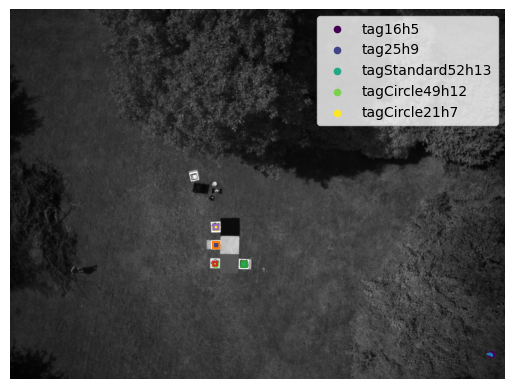

In [125]:
show_tags(images_single_tag[1], False)

In [133]:
def get_panel_single(img, valid_ids=None):
    tags = detect_tags(img, valid_ids)
    tags = sum(tags, [])
    panels = []
    for tag in tags:
        corners = list(tag.getCorners(tuple([0.0] * 8)))
        corners = np.array(list((zip(corners[::2], corners[1::2]))))

        towards_panel = corners[2] - corners[1]
        tag_size_adjusted = tag_size
        if tag.getFamily() in tag_pixel_conversions.keys():
            tag_size_adjusted = np.linalg.norm(towards_panel) * tag_pixel_conversions[tag.getFamily()]
        towards_panel = towards_panel / np.linalg.norm(towards_panel)
        center = np.array([tag.getCenter().x, tag.getCenter().y])
        tag_panel_border = center + towards_panel * (tag_size_adjusted / 2)
        panel_length = towards_panel * panel_size_pixel
        half_panel_length = panel_length / 2
        panel_midpoint_to_edge = [-half_panel_length[1], half_panel_length[0]]
        edgeA = tag_panel_border + panel_midpoint_to_edge
        edgeB = tag_panel_border - panel_midpoint_to_edge
        edgeC = tag_panel_border + panel_length - panel_midpoint_to_edge
        edgeD = tag_panel_border + panel_length + panel_midpoint_to_edge
        panels.append((tag, (edgeA, edgeB, edgeC, edgeD)))
    return panels

In [134]:
def show_panels_single(img, valid_ids):
    fig_2d = plt.figure()
    ax = fig_2d.subplots(1, 1)
    ax.imshow(img, cmap="grey")
    panels = get_panel_single(img, valid_ids)
    for (tag, edges), color in zip(panels, colors):
        ax.scatter(tag.getCenter().x, tag.getCenter().y, color=color)
        x, y = zip(*edges)

        # Append the first point to the end to close the rectangle/polygon
        # Append the first point to the end to close the rectangle/polygon
        x = list(x) + [x[0]]
        y = list(y) + [y[0]]
        ax.plot(x, y, color=color, linewidth=2)
    fig_2d.show()

C:\Users\ninja\AppData\Local\Temp\ipykernel_6260\1560983101.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_2d.show()


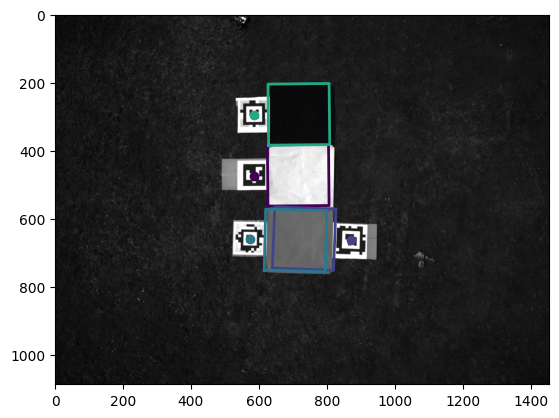

In [136]:
show_panels_single(images_single_tag[0], [4])

## 3D Pose Estimation

In [24]:
# Helper functions

def rotate_vector(vector, axis, degrees):
    theta = degrees * (np.pi / 180.0)
    axis = axis / norm(axis)  # normalize the rotation vector first
    rot = Rotation.from_rotvec(theta * axis)
    new_v = rot.apply(vector)
    return new_v


def project_to_image_plane(X, Y, Z,
                           horizontal_focal_length_pixels, vertical_focal_length_pixels,
                           horizontal_focal_center_pixels, vertical_focal_center_pixels):
    """
    Projects a 3D world point (X, Y, Z) into 2D image plane coordinates (u, v).

    Parameters:
    X, Y, Z: float
        3D coordinates of the point in world space.
    horizontal_focal_length_pixels: float
        Focal length of the camera in the horizontal direction (in pixels).
    vertical_focal_length_pixels: float
        Focal length of the camera in the vertical direction (in pixels).
    horizontal_focal_center_pixels: float
        The x-coordinate of the principal point (optical center) in the image.
    vertical_focal_center_pixels: float
        The y-coordinate of the principal point (optical center) in the image.

    Returns:
    u, v: float
        2D pixel coordinates in the image plane.
    """
    # Project onto the 2D image plane
    u = (X * horizontal_focal_length_pixels) / Z + horizontal_focal_center_pixels
    v = (Y * vertical_focal_length_pixels) / Z + vertical_focal_center_pixels

    return u, v

In [40]:
def get_panel_single_3D(img, valid_ids):
    panels = []
    tags = [detector.detect(img) for detector in detectors]
    #Flatten
    tags = sum(tags, [])

    def estimate(tag):
        tag_size_adjusted = (tag_size, tag_size)
        if tag.getFamily() in conversions_cm.keys():
            tag_size_adjusted = conversions_cm[tag.getFamily()]
        pose_estimator = AprilTagPoseEstimator(
            AprilTagPoseEstimator.Config(tag_size_adjusted[0], horizontal_focal_length_pixels,
                                         vertical_focal_length_pixels,
                                         horizontal_focal_center_pixels, vertical_focal_center_pixels))
        return tag_size_adjusted, pose_estimator.estimate(tag)

    estimates = [estimate(tag) for tag in tags if verify_detections(tag, valid_ids)]
    # As we know that all panels are flat on the ground we can improve the pose estimate by scaling the estimation so all panel are at the same mean height
    mean_distance = np.mean([estimate.translation()[2] for (tag_size_adjusted, estimate) in estimates])
    for tag_size_adjusted, estimate in estimates:
        # The estimated rotation is a vector that points up and away form the panel (Z axis is up towards the camera)
        tag_orientation = [estimate.rotation().x, estimate.rotation().y, estimate.rotation().z]
        # Scale the rotation vector to the tag_size
        tag_orientation = tag_orientation / np.linalg.norm(tag_orientation)
        # The tag orientation is then rotated to face the "up" side of the tag when thinking in terms of a 2d paper print. (Towards the panel on the ground)
        tag_up_dir = rotate_vector(tag_orientation, [0, 1, 0], 90.0)
        # Calculate vectors that point in the direction of the panel edges
        # Use mean_distance to put all tags at the same distance
        tag_center = [estimate.translation().x, estimate.translation().y, mean_distance]
        distance_scale = estimate.translation().z / mean_distance
        tag_panel_border = tag_center + tag_up_dir * distance_scale * (tag_size_adjusted[1] / 2)
        panel_length = tag_up_dir * panel_size_m
        half_panel_length = panel_length / 2
        panel_midpoint_to_edge = rotate_vector(half_panel_length, [0, 0, 1], 90.0)
        edgeA = tag_panel_border + panel_midpoint_to_edge
        edgeB = tag_panel_border - panel_midpoint_to_edge
        edgeC = tag_panel_border + panel_length - panel_midpoint_to_edge
        edgeD = tag_panel_border + panel_length + panel_midpoint_to_edge
        panels.append((estimate, (edgeA, edgeB, edgeC, edgeD)))
    return panels


def project_edges(edges):
    return [project_to_image_plane(*edge,
                                   horizontal_focal_length_pixels,
                                   vertical_focal_length_pixels,
                                   horizontal_focal_center_pixels,
                                   vertical_focal_center_pixels) for edge in edges]

In [41]:
def show_panels_single_3D_in_2D(img, valid_ids):
    fig_2d = plt.figure()
    ax = fig_2d.subplots(1, 1)
    ax.imshow(img, cmap="grey")
    panels_3d = get_panel_single_3D(img, valid_ids)
    panels = [(project_edges([estimate.translation()]), project_edges(edges)) for (estimate, edges) in panels_3d]
    for ([estimate], edges), color in zip(panels, colors):
        ax.scatter(estimate[0], estimate[1], color=color)
        x, y = zip(*edges)

        # Append the first point to the end to close the rectangle/polygon
        x = list(x) + [x[0]]
        y = list(y) + [y[0]]
        ax.plot(x, y, color=color)
    fig_2d.show()

In [42]:
def show_panel_single_3D(img, valid_ids):
    fig_3d = plt.figure()
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    ax_3d.set_xlim(-5, 5)
    ax_3d.set_ylim(-5, 5)
    ax_3d.set_zlim(25)
    color = "green"

    def print_location(point):
        ax_3d.scatter(*point, marker="o", color=color, s=2)

    panels_3d = get_panel_single_3D(img, valid_ids)
    for (estimate, edges), color in zip(panels_3d, colors):
        ax_3d.quiver(*estimate.translation().toVector(),
                     *rotate_vector([estimate.rotation().x, estimate.rotation().y, estimate.rotation().z], [0, 1, 0],
                                    90.0),
                     color=color)
        print_location(estimate.translation())
        edgeA, edgeB, edgeC, edgeD = edges
        print_location(edgeA)
        print_location(edgeB)
        print_location(edgeC)
        print_location(edgeD)
        ax_3d.quiver(*edgeA, *(edgeB - edgeA), color=color)
        ax_3d.quiver(*edgeB, *(edgeC - edgeB), color=color)
        ax_3d.quiver(*edgeC, *(edgeD - edgeC), color=color)
        ax_3d.quiver(*edgeD, *(edgeA - edgeD), color=color)
    fig_3d.show()


C:\Users\ninja\AppData\Local\Temp\ipykernel_6260\4198426447.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_2d.show()
C:\Users\ninja\AppData\Local\Temp\ipykernel_6260\3642529187.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_3d.show()


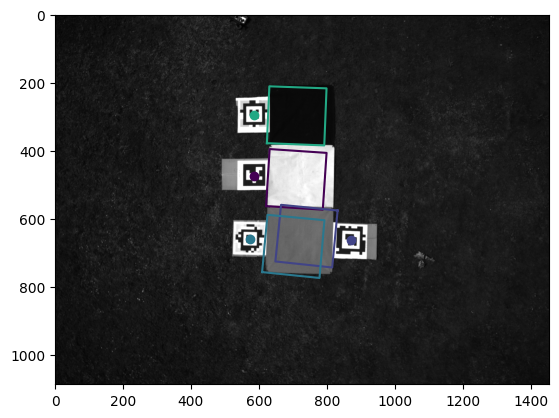

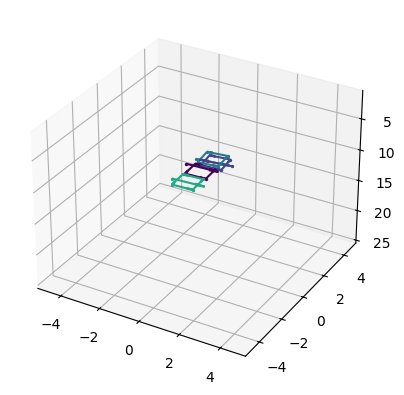

In [43]:
show_panels_single_3D_in_2D(images_single_tag[0], [4])
show_panel_single_3D(images_single_tag[0], [4])